# Exposed and Infected class calculations

This notebook implements methods to calculate exposed and infected classes based on death and confirmed case numbers

In [1]:
import pandas as pd
import numpy as np
from scipy.stats.distributions import gamma

from epimodel import read_csv
# This is not stable enough to be usable
#from modeling.nowcasting.nowcasting import exp_model

In [2]:
csse_ds = read_csv("../../data/johns-hopkins.csv")

csse_ds = csse_ds.loc[csse_ds.index.dropna(),:]
csse_ds = csse_ds.loc[~(csse_ds.index.get_level_values(0)=='CA'),:]

This is the infection to death distribution from the [ICL Paper](https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-30-COVID19-Report-13.pdf)

IFR is from [Wu et. al](https://www.nature.com/articles/s41591-020-0822-7) w/25% asymptomatic

In [3]:
ICL_ITD = gamma(1/0.45**2,0,18.8*0.45**2)

DEATHS_DAYS = np.array([ICL_ITD.cdf(a+1)-ICL_ITD.cdf(a) for a in range(40)])

In [4]:
# see heading "Align Confirmed Cases" below

def transformCases(s):
    shifted = s.diff().shift(-7)
    return shifted


# This isn't very accurate, and a better nowcast might be useful.
# However, wherever we use it we then take a convolutions with a distributions with 
# very small weight on the relevant days, and it's probably not orders of magnitude out
# which an exponential fit can be

def fillforward(orig,fill=7, pred=7):
    s = orig.copy()
    data_x = np.linspace(1,pred,pred)
    data_pred = np.linspace(pred+1,pred+1+fill,fill)
    try:
        s[-fill:] = np.poly1d(np.polyfit(data_x,
                                       s[-(pred+fill):-fill],1))(data_pred)
    except ValueError:
        print('Invalid data for linear fit', s[-(pred+fill):-fill])
        # In this case, we really don't know what cases are likely to do
        s[-fill:] = np.nan
        return s
    return s

# see heading "Comparison of Expected Deaths" below


def expectedDeaths(s,fatality=0.008):
    s_pad = np.pad(s,(len(DEATHS_DAYS)-2,0),constant_values=0)
    cv = np.convolve(fillforward(s_pad),DEATHS_DAYS,'valid')
    pw = len(s)-len(cv)
    return fatality*np.pad(cv,(pw,0),"constant",constant_values=np.nan)

## see heading "Recovered, Infectious and Exposed Classes" below


def lik_r(i,mu=0.5):
    return np.exp(-mu*i)

norm = lik_r(np.arange(1,100)).sum()

def r(i):
    return lik_r(i)/norm

def R(ti):
    ti_pad = np.pad(ti,(40,0),'constant',constant_values=0)
    cv = np.convolve(ti_pad,r(np.arange(1,42)),'valid')
    pw = len(ti)-len(cv)
    return np.pad(cv,(pw,0),"constant",constant_values=0)

norm_I = lik_r(np.arange(1,100),0.2).sum()

def inf(i):
    return lik_r(i,0.2)/norm_I

def E2I(ever_exposed):
    ee_pad = np.pad(ever_exposed,(40,0),'constant',constant_values=0)
    cv = np.convolve(ee_pad,inf(np.arange(1,42)),'valid')
    pw = len(ever_exposed)-len(cv)
    return np.pad(cv,(pw,0),"constant",constant_values=0)

# Calculate ascertainment, true infection rates, exposed and infectious classes and add as new columns
# Returns a much smaller dataframe, as 

def filtered_mean(m,indices):
    return m[indices].mean()

def ascertainment(csse_ds,fatality = 0.008):
    csse_df = csse_ds.copy()
    csse_df['New confirmed shifted'] = csse_df['Confirmed'].groupby(level=0).transform(transformCases)
    csse_df['New deaths'] = csse_df['Deaths'].groupby(level=0).transform(lambda x: x.diff())
    
    g = csse_df.groupby(level=0)
    
    csse_df['Expected deaths'] = g['New confirmed shifted'].transform(expectedDeaths,fatality=fatality)
    
    indices = csse_df['New deaths']>=5
    
    csse_df['Ascertainment'] = np.nan
    
    csse_df.loc[indices,'Ascertainment'] = pd.to_numeric(csse_df.loc[indices,'Expected deaths']
                                            /csse_df.loc[indices,'New deaths'])
    
    csse_df['New cases true'] = (csse_df['New confirmed shifted']
                                             /csse_df.groupby(level=0)['Ascertainment'].transform(filtered_mean,indices))

    g2 = csse_df.groupby(level=0)
    csse_df['Exposed'] = g2['New cases true'].transform(np.cumsum) - g2['New cases true'].transform(lambda x: np.cumsum(E2I(x)))
    csse_df['Recovered'] = g2['New cases true'].transform(lambda x: np.cumsum(R(E2I(x))))
    csse_df['Infectious'] = g2['New cases true'].transform(lambda x: np.cumsum(E2I(x))) - csse_df['Recovered']
    return csse_df

## Align confirmed cases

The first step is to calculate new infections timeshifted back by 7 days. The figure 7 comes from:
 - 5.5 days infection-to-symptoms (https://docs.google.com/spreadsheets/d/1yzVSp71jiCsoD_L6sXchfg8L9OF0tGHWEnCdfvF73Ac/edit#gid=1242721729)
 - 4 days symptoms-to-confirmation (also https://docs.google.com/spreadsheets/d/1yzVSp71jiCsoD_L6sXchfg8L9OF0tGHWEnCdfvF73Ac/edit#gid=1242721729)
 - Subtract two days as exponential growth means that fast confirmations will be overrepresented
 
We could in principle calculate this properly as we do with time to death, but for the purposes of calculating the true number of cases it is less crucial than calculating infection to death properly.

There may also be a lag in the reporting of deaths. However, a lag of more than 2 days produces unconvincing output (e.g. sharply rising ascertainment rates).

In [5]:
csse_demo = csse_ds.copy()

csse_demo['New Confirmed Shifted'] = csse_demo['Confirmed'].groupby(level=0).transform(transformCases)
csse_demo['New Deaths'] = csse_demo['Deaths'].groupby(level=0).transform(lambda x: x.diff())

csse_demo.loc['IT'][-10:]

,Recovered,Confirmed,Deaths,Active,New Confirmed Shifted,New Deaths
Date,,,,,,
2020-03-29 00:00:00+00:00,13030.0,97689.0,10779.0,73880.0,4316.0,756.0
2020-03-30 00:00:00+00:00,14620.0,101739.0,11591.0,75528.0,3599.0,812.0
2020-03-31 00:00:00+00:00,15729.0,105792.0,12428.0,77635.0,3039.0,837.0
2020-04-01 00:00:00+00:00,16847.0,110574.0,13155.0,80572.0,NaN,727.0
2020-04-02 00:00:00+00:00,18278.0,115242.0,13915.0,83049.0,NaN,760.0
2020-04-03 00:00:00+00:00,19758.0,119827.0,14681.0,85388.0,NaN,766.0
2020-04-04 00:00:00+00:00,20996.0,124632.0,15362.0,88274.0,NaN,681.0
2020-04-05 00:00:00+00:00,21815.0,128948.0,15887.0,91246.0,NaN,525.0
2020-04-06 00:00:00+00:00,22837.0,132547.0,16523.0,93187.0,NaN,636.0


## Comparison of Expected Deaths

The number of deaths on day $i$ should be
$$ d_i = f \sum_j p_{i-j} t_j $$
where $f$ is the infection fatality rate, $p_k$ is the probability of dieing $k$ days after being infected and $t_j$ is the true number of cases on day $j$.

Suppose that there is a fixed ascertainment rate $a$ such that confirmed cases $c_j=a t_{j-7}$ for all $j$. Then 

$$ a = \frac{f\sum_j p_{i-j} c_{j+7}}{d_{i}} $$

**Note** This is actually *lagged* ascertainment rate - it asks "what fraction of new cases today are detected 7 days later". I don't directly estimate an instantaneous ascertainment rate as this is very sensitive to the short term trajectory of infections, which, as I note above, I can't yet forecast. What we can in fact calculate is:

$$ t_{i-7} = \frac{c_i}{a}  $$

Th

In [6]:
g = csse_demo.groupby(level=0)

csse_demo['Expdeaths'] = g['New Confirmed Shifted'].transform(expectedDeaths,fatality=0.008)
csse_demo['Ascertainment'] = csse_demo['Expdeaths']/csse_demo['New Deaths']

According to this method, ascertainment in Italy may be rising slightly

In [7]:
csse_demo.loc['IT'][-10:]

,Recovered,Confirmed,Deaths,Active,New Confirmed Shifted,New Deaths,Expdeaths,Ascertainment
Date,,,,,,,,
2020-03-29 00:00:00+00:00,13030.0,97689.0,10779.0,73880.0,4316.0,756.0,32.140636,0.042514
2020-03-30 00:00:00+00:00,14620.0,101739.0,11591.0,75528.0,3599.0,812.0,33.267564,0.040970
2020-03-31 00:00:00+00:00,15729.0,105792.0,12428.0,77635.0,3039.0,837.0,34.232284,0.040899
2020-04-01 00:00:00+00:00,16847.0,110574.0,13155.0,80572.0,NaN,727.0,35.034320,0.048190
2020-04-02 00:00:00+00:00,18278.0,115242.0,13915.0,83049.0,NaN,760.0,35.670665,0.046935
2020-04-03 00:00:00+00:00,19758.0,119827.0,14681.0,85388.0,NaN,766.0,36.129054,0.047166
2020-04-04 00:00:00+00:00,20996.0,124632.0,15362.0,88274.0,NaN,681.0,36.421487,0.053482
2020-04-05 00:00:00+00:00,21815.0,128948.0,15887.0,91246.0,NaN,525.0,36.536010,0.069592
2020-04-06 00:00:00+00:00,22837.0,132547.0,16523.0,93187.0,NaN,636.0,36.472564,0.057347


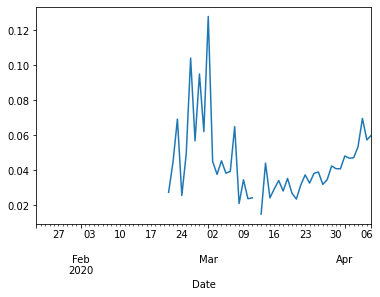

In [8]:
csse_demo.loc['IT','Ascertainment'].plot()

While ascertainment in Brazil looks steady

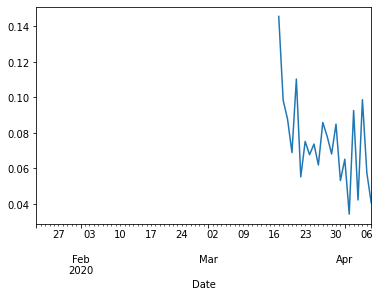

In [9]:
csse_demo.loc['BR','Ascertainment'].plot()

# Filter out small numbers of deaths

The method doesn't work well with small numbers of deaths per day. Fully Bayesian treatment probably handles this case better, or even variance weighted averaging. However, for now I just remove days with small numbers of new deaths from consideration.

## Recovered, Infectious and Exposed Classes

The infectious class is given by 

$$ I_i = \sum_{j} q_{i-j} t_j - \sum_{j} r_{i-j} t_j $$

and the exposed class by 

$$ E_i = \sum_j (1-q_{i-j}) t_j $$

finally, the recovered class is given by

$$ R_i = \sum_j r_{i-j} t_j $$

Where $q_n$ is the distribution of the time from being exposed to being infectious, $E_i$ and $I_i$ the size of the exposed and infected classes on day $i$ and $t_j$ the true number of new cases on day $j$ as above

To make the infectious class match [GLEAM's treatment](http://www.gleamviz.org/simulator/models/), we take $q_{i-j}=A e^{-(i-j)\epsilon}$ where $A$ is some normalising constant. That is, the transition probability is an exponential. Currently we use $\epsilon=0.2$.

To get a recovery rate that matches our use of GLEAM, we could take $r_i = B e^{-i\mu}$ where $\mu=0.5$ is the rate of recovery from GLEAM and $B$ is a normalising constant. This is a bit unrealistic, but alternative approaches are tricky to implement.

Another possibility is to take the "serial interval" distribution from https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-30-COVID19-Report-13.pdf (note that this seems to be the distribution of probability of infection, not probability of first infection, so it's not acutally the serial interval). However, we need to turn this nonexponential distribution into an exponential infectious class, and figuring out how to approximate this appropriately seems hard.

In [16]:

low = ascertainment(csse_ds,0.004)
mid = ascertainment(csse_ds,0.008)
high = ascertainment(csse_ds,0.015)

In [23]:

mid.loc['IT'][-20:]

,Recovered,Confirmed,Deaths,Active,New confirmed shifted,New deaths,Expected deaths,Ascertainment,New cases true,Exposed,Infectious
Date,,,,,,,,,,,
2020-03-19 00:00:00+00:00,1.200057e+06,41035.0,3405.0,33190.0,6203.0,427.0,15.135829,0.035447,147858.504967,545349.725559,175562.165761
2020-03-20 00:00:00+00:00,1.318078e+06,47021.0,4032.0,38549.0,5909.0,627.0,16.927245,0.026997,140850.541004,561813.263625,181928.367172
2020-03-21 00:00:00+00:00,1.439888e+06,53578.0,4825.0,42681.0,5974.0,793.0,18.766982,0.023666,142399.920792,576560.993360,187770.100217
2020-03-22 00:00:00+00:00,1.563762e+06,59138.0,5476.0,46638.0,5217.0,651.0,20.631582,0.031692,124355.605419,573861.977261,190950.846168
2020-03-23 00:00:00+00:00,1.686711e+06,63927.0,6077.0,50826.0,4050.0,601.0,22.498702,0.037435,96538.279077,548877.309189,189524.936004
2020-03-24 00:00:00+00:00,1.807322e+06,69176.0,6820.0,54030.0,4053.0,743.0,24.342863,0.032763,96609.788914,528480.140341,185920.991748
2020-03-25 00:00:00+00:00,1.926299e+06,74386.0,7503.0,57521.0,4782.0,683.0,26.132039,0.038261,113986.679148,526007.345305,183403.023486
2020-03-26 00:00:00+00:00,2.043916e+06,80589.0,8215.0,62013.0,4668.0,712.0,27.832060,0.039090,111269.305366,521758.014604,181305.151371
2020-03-27 00:00:00+00:00,2.160263e+06,86498.0,9134.0,66414.0,4585.0,919.0,29.412618,0.032005,109290.866560,516659.197979,179347.983077


# Some really dodgy curve fitting

To see if there's a viable simple approximation for the infectious class

In [440]:
# def approx(df,lag,window,col='Deaths',ifr=0.008):
#     return df.groupby(level=0)[col].diff(window).transform(lambda x: x*np.minimum(x/x.shift(int(lag)),10)/ifr).replace(np.inf,np.nan)

def approx(df,lag,fit,col='New deaths',ifr=0.008):
    return df.groupby(level=0)[col].transform(lambda x: x*np.minimum((x/x.shift(fit))**(lag/fit),5)/ifr).replace(np.inf,np.nan)
    

def mse(s,t):
    t = t.replace(0,1)
    return ((s-t)/t).mean(), np.abs((s-t)/t).mean(), np.sqrt(((s-t)**2).mean())

INDICES = ((mid.index.get_level_values(1)>pd.Timestamp('2020-03-15').tz_localize('UTC'))
           &
          (mid.index.get_level_values(0)!='CN-HB')
           &
          (mid['Deaths']>10))

In [441]:
for l in range(3,25):
    for f in range(2,10):
        ap = approx(mid,l,f,col='New deaths')[INDICES]
        mi = mid[INDICES]
        print(l,f,mse(ap,mi['Infectious']))

3 2 (-0.40020161389367276, 0.6921701282880028, 34585.20997122468)
3 3 (-0.44855197742668534, 0.6902619708945762, 34429.55886680074)
3 4 (-0.43877265024856016, 0.670908423885643, 33542.92237510516)
3 5 (-0.44877801708363424, 0.644461957202096, 33027.42556993997)
3 6 (-0.4259729057596157, 0.6500900461320298, 32775.17585323477)
3 7 (-0.41367594296320576, 0.6124347952534281, 32043.743415936024)
3 8 (-0.38489137912798704, 0.6163064004841599, 32696.96981467479)
3 9 (-0.34866049055738557, 0.6145055564847455, 33521.19367981753)
4 2 (-0.33426644756122537, 0.6917574405969505, 33303.86808177785)
4 3 (-0.3746159983418591, 0.6754786702782268, 32041.46191248084)
4 4 (-0.3726772310787621, 0.6706846931163126, 30489.019971216014)
4 5 (-0.3796839525620043, 0.6240050256201906, 30171.591262963295)
4 6 (-0.34915788552160076, 0.6295332383817994, 29311.69386561432)
4 7 (-0.34337519936477895, 0.5985243781110233, 29137.030818098418)
4 8 (-0.3206807264989836, 0.5918050003024152, 28905.21122120049)
4 9 (-0.29302

18 5 (-0.0464511700175593, 0.6643231847842628, 40285.480523763705)
18 6 (-0.12588408554046912, 0.7997093863131787, 39952.25504063164)
18 7 (0.003172184384793493, 0.667700991597665, 37430.77628780626)
18 8 (0.02239609008147311, 0.6553236475292077, 41884.831200701075)
18 9 (0.038156570330570135, 0.6699183674131621, 42334.64321269348)
19 2 (-0.1070457907728903, 0.758096580070757, 43768.723112797656)
19 3 (-0.11044942004428197, 0.731075899600843, 40744.61589820393)
19 4 (-0.055744013190206464, 0.7181907681021434, 39943.72905304356)
19 5 (-0.04058895582128568, 0.6660496507650017, 40867.02431184719)
19 6 (0.008199931616670911, 0.6776923592360713, 39626.02103814026)
19 7 (0.007286731735752317, 0.6701887262905221, 38334.555275639956)
19 8 (0.028193788399990934, 0.6578296790450341, 42381.90862082358)
19 9 (0.04786488040223842, 0.6709304751743745, 43940.9943538086)
20 2 (-0.10723765356697641, 0.762499365210899, 44265.25623147428)
20 3 (-0.10756981324285825, 0.7322969814440163, 41217.352106313905

In [390]:
ap = approx(mid,15,col='New deaths')[INDICES]
mid.loc[INDICES,'Approx'] = ap

In [ ]:
np.cum